## 중고차 가격 예측 모델

In [16]:

import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [9]:
usedcar_df=pd.read_csv('./data/Dubizzle_used_car_sales.csv')
usedcar_df.head()

,title,price_in_aed,kilometers,body_condition,mechanical_condition,seller_type,body_type,no_of_cylinders,transmission_type,regional_specs,horsepower,fuel_type,steering_side,year,color,emirate,motors_trim,company,model,date_posted
0,MITSUBISHI PAJERO 3.5L / 2013,26000,167390,Perfect inside and out,Perfect inside and out,Dealer,SUV,6,Automatic Transmission,GCC Specs,Unknown,Gasoline,Left Hand Side,2013.0,Silver,Dubai,GLS,mitsubishi,pajero,13/05/2022
1,chevrolet silverado,110000,39000,Perfect inside and out,Perfect inside and out,Dealer,SUV,8,Automatic Transmission,North American Specs,400 - 500 HP,Gasoline,Left Hand Side,2018.0,White,Sharjah,1500 High Country,chevrolet,silverado,14/01/2022
2,MERCEDES-BENZ E300 - 2014 - GCC SPEC - FULL OP...,78000,200000,Perfect inside and out,Perfect inside and out,Dealer,Sedan,6,Automatic Transmission,GCC Specs,400 - 500 HP,Gasoline,Left Hand Side,2014.0,Blue,Sharjah,E 300,mercedes-benz,e-class,05/05/2022
3,WARRANTY UNTIL APR 2023 || Ferrari 488 Spider ...,899000,27000,Perfect inside and out,Perfect inside and out,Dealer,Hard Top Convertible,8,Automatic Transmission,GCC Specs,600 - 700 HP,Gasoline,Left Hand Side,2018.0,Red,Dubai,Standard,ferrari,488-spider,30/04/2022
4,USED RENAULT DOKKER 2020,33000,69000,Perfect inside and out,Perfect inside and out,Owner,Wagon,4,Manual Transmission,GCC Specs,Less than 150 HP,Gasoline,Left Hand Side,2020.0,White,Dubai,Standard,renault,dokker,13/05/2022


In [10]:
usedcar_df.shape

(9970, 20)

In [12]:
usedcar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9970 entries, 0 to 9969
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 9965 non-null   object 
 1   price_in_aed          9970 non-null   int64  
 2   kilometers            9970 non-null   int64  
 3   body_condition        9970 non-null   object 
 4   mechanical_condition  9970 non-null   object 
 5   seller_type           9970 non-null   object 
 6   body_type             9970 non-null   object 
 7   no_of_cylinders       9889 non-null   object 
 8   transmission_type     9970 non-null   object 
 9   regional_specs        9970 non-null   object 
 10  horsepower            9970 non-null   object 
 11  fuel_type             9970 non-null   object 
 12  steering_side         9970 non-null   object 
 13  year                  9000 non-null   float64
 14  color                 9970 non-null   object 
 15  emirate              

#### 결측치 확인

In [18]:
usedcar_df.isnull().sum()

title                     5
price_in_aed              0
kilometers                0
body_condition            0
mechanical_condition      0
seller_type               0
body_type                 0
no_of_cylinders          81
transmission_type         0
regional_specs            0
horsepower                0
fuel_type                 0
steering_side             0
year                    970
color                     0
emirate                   0
motors_trim              28
company                   0
model                     0
date_posted               0
dtype: int64

#### 결측치에 해당하는 데이터타입 확인

In [25]:
for col in['title','no_of_cylinders','year','motors_trim']:
   print(f'{col}: {usedcar_df[col].dtype}')

title: object
no_of_cylinders: object
year: float64
motors_trim: object


## 해당 데이터타입이 후에 미칠 영향 분석

### 1. object 타입 컬럼: title, no_of_cylinders, motors_trim
- object는 문자열(카테고리, 텍스트 등) 데이터가 들어있다는 의미.

- 머신러닝 모델(특히 scikit-learn의 회귀 모델)은 수치형 데이터만 인식하고 학습함.

-  object 타입을 아무 처리 없이 모델에 넣으면:

    \- 학습이 안되거나,에러 발생 

    \- 잘못 인코딩했을 땐 의미 없는 숫자로 변환되어 노이즈로 작용

결과적으로 RMSE 높아지고, R² 낮아짐(성능저하)



### 2. float 타입 컬럼: year

- 연식(year)이 소수점(float)으로 되어 있음.

- 원래는 int여야 정상.

- 결측치(NaN)가 있어 자동으로 float64가 된 것일 수 있음.

- 결측치를 적절히 처리하지 않으면 데이터 손실 or 이상치 발생


이것도 모델 성능 저하로 이어질 수 있음.

## 미칠 영향에 따른 처리방안

### 1. object 타입 컬럼: title, no_of_cylinders, motors_trim

- 대부분 자동차의 등급, 옵션, 이름 등 범주형 변수

- 모델에 바로 넣으면 안되고, (One-hot) encoding 등으로 변환 필요.

### 2. floar 타입 컬럼: year

- RandomForestRegressor(회귀모델)로 상관관계를 파악하여 예측한 값으로 채우기

### 전처리 시작

In [33]:
df1=usedcar_df.copy()

In [34]:
df1['title']=df1['title'].fillna('Unknown')

In [35]:
usedcar_df['no_of_cylinders'].value_counts()

no_of_cylinders
6          3325
4          2993
8          2986
12          366
Unknown      57
3            56
10           53
5            53
Name: count, dtype: int64

In [36]:
print(usedcar_df['no_of_cylinders'].isnull().sum())


81


#### 결측치와 Unknown값이 따로 있는걸 확인함

In [37]:
df1['no_of_cylinders']=df1['no_of_cylinders'].replace('Unknown',np.nan)
df1['no_of_cylinders']=df1['no_of_cylinders'].astype(float)
df1['no_of_cylinders']=df1['no_of_cylinders'].fillna(-1).astype(int)

In [40]:
df1['no_of_cylinders'].value_counts()  #결측치 대체 확인

no_of_cylinders
 6     3325
 4     2993
 8     2986
 12     366
-1      138
 3       56
 10      53
 5       53
Name: count, dtype: int64

In [42]:
# 결측치(NaN) 개수
print("결측치 개수:", df1['motors_trim'].isnull().sum())

# 'Unknown' 값 개수
print("'Unknown' 개수:", (df1['motors_trim'] == 'Unknown').sum())

결측치 개수: 28
'Unknown' 개수: 0


In [43]:
df1['motors_trim']=df1['motors_trim'].fillna('Unknown')

#### 랜덤포레스트 모델을 이용한 year컬럼 전처리 

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#결측치가 아닌 행과 결측치 행 분리
notnull=df1[df1['year'].notnull()]
isnull=df1[df1['year'].isnull()]

#예측에 사용할 피처 선정(id,year,price는 제외)
feature_cols=[col for col in df1.columns if col not in ['id','year','price_in_aed']]

#범주형 변수 인코딩(get_dummies 활용)
X_train=pd.get_dummies(notnull[feature_cols])
X_pred=pd.get_dummies(isnull[feature_cols]) #학습할때도, 예측할때도 모두 수치형(인코딩) 입력만 받아들일 수 있기때문

#train/predict 컬럼 불일치 방치(맞춰주기)
X_pred=X_pred.reindex(columns=X_train.columns, fill_value=0)

get_dummies(원-핫 인코딩)을 각 데이터프레임에 따로 적용하면,  
train(학습 데이터)과 predict(예측 데이터)의 컬럼(피처) 구조가 달라질 수 있다.

예를 들어, train엔 ‘motors_trim_LUX’가 있는데,   
predict에는 이 값이 하나도 없어서 컬럼 자체가 안 만들어질 수도 있고    
반대로, predict엔 새로운 값이 등장할 수도 있다.    
머신러닝 모델은 입력 피처(컬럼)가 반드시 동일해야 학습한 구조와 똑같은 형태로 예측할 수 있다.    

In [60]:
y_train=notnull['year']

#회귀모델 학습

#X_train은 예측에 사용할 정보들(컬럼들),y_train(정답,종속변수,target)은 맞춰야 할 값; 여기서는 year
#X_train으로 y_train을 예측하는 방법”을 모델에게 가르치는 과정
rf=RandomForestRegressor(n_estimators=300,random_state=42)
rf.fit(X_train,y_train) 

#결측치 예측
year_pred=rf.predict(X_pred)

#예측값 소수점 반올림
year_pred=year_pred.round().astype(int)

ValueError: Found array with 0 sample(s) (shape=(0, 11081)) while a minimum of 1 is required by RandomForestRegressor.

In [62]:
# 원본 df1에 예측값 반영
df1['year'] = df1['year'].astype(int)

In [63]:
print(df1['year'].isnull().sum() == 0)  # 결측치 다 채워짐

True


### 불균형 해소(오버샘플링)

In [82]:
# 고가 차량 등 소수 구간 데이터 오버샘플링 예시
from sklearn.utils import resample

high_price = df1[df1['price_in_aed'] > df1['price_in_aed'].quantile(0.9)]  # 상위 10% 고가차
df1_balanced = pd.concat([
    df1,  # 전체 데이터
    resample(high_price, replace=True, n_samples=len(df1)//5, random_state=42)  # 고가차 오버샘플링
])

## feature/target 나누기

In [83]:
# 예측목표는 price로 가정
target='price_in_aed'

#id,price_in_aed(타겟) 제외한 나머지 피처
feature_cols=[col for col in df1.columns if col not in ['id','price_in_aed']]

X=df1[feature_cols]
y=df1[target]

In [84]:
X=pd.get_dummies(X, drop_first=True)

In [85]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [86]:
# 피처 스케일링(표준화)

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

### 모델 학습

In [87]:
from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor( n_estimators=1000,         # 트리 개수(200~300 사이, 속도 고려)
    max_depth=20,             # 트리 최대 깊이(복잡도 제한)
    min_samples_split=3,      # 분할 최소 샘플 수
    min_samples_leaf=1,       # 리프노드 최소 샘플 수
    random_state=42,
    n_jobs=-1                 # 모든 CPU 코어 사용
)
rf.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=20, min_samples_split=3, n_estimators=1000,
                      n_jobs=-1, random_state=42)

### 예측

In [88]:
y_pred=rf.predict(X_test_scaled)

### 성능평가

In [89]:
from sklearn.metrics import mean_squared_error,r2_score

rmse=np.sqrt(mean_squared_error(y_test,y_pred))
r2=r2_score(y_test,y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 338762.5732502252
R2: 0.5965589598581398


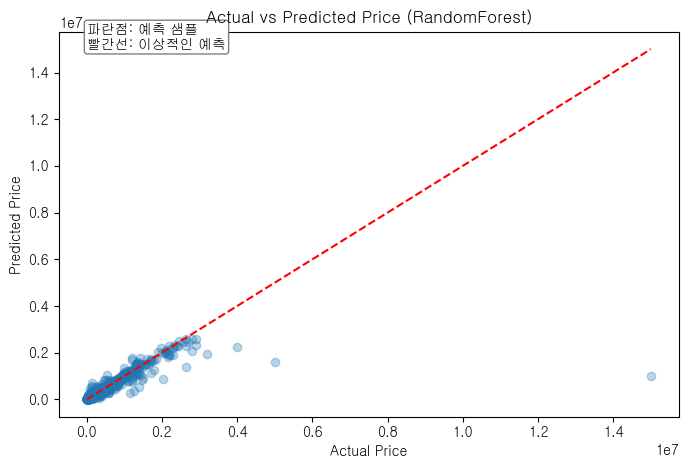

In [90]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Gulim'

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (RandomForest)")
plt.text(
    y_test.min(),                   # x좌표(좌상단에 배치)
    y_test.max(),                   # y좌표
    "파란점: 예측 샘플\n빨간선: 이상적인 예측",
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.2')
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### XGBoost 모델로

In [91]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=1200, max_depth=16, learning_rate=0.03,
    subsample=0.9, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=16, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1200,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

#### 예측

In [92]:
y_pred=model.predict(X_test_scaled)

#### 성능평가

In [94]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 337470.686871938
R²: 0.5996301738317882


#### 시각화

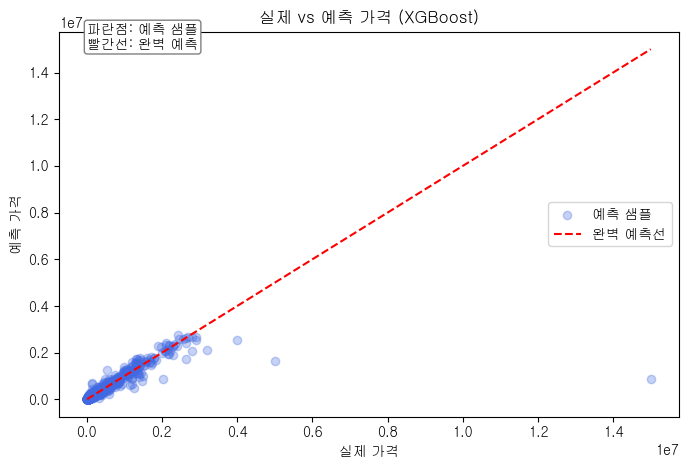

In [96]:

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Gulim')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='royalblue', alpha=0.3, label='예측 샘플')
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', label='완벽 예측선'
)

plt.xlabel("실제 가격")
plt.ylabel("예측 가격")
plt.title("실제 vs 예측 가격 (XGBoost)")

# 간단 설명 박스 추가
plt.text(
    y_test.min(), y_test.max(),
    "파란점: 예측 샘플\n빨간선: 완벽 예측",
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.2')
)

plt.legend()
plt.show()